## Data Reading

First, we are just going to read the information of the paleamagnetic poles. This notebook creates proccessed versions of the PP and VGPs data in a python-friendly format. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import seaborn as sns

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag

from scripts.auxiliar import get_files_in_directory, spherical2cartesian

We first define the current path we are currently working on and define the directories of the data files with respect to it. 

In [2]:
current_path = os.getcwd() 
data_path = current_path + '/data'
data_path_PP = data_path + "/poles_NAM"
file_name = "/NAM_poles_0_130.xlsx"

In [3]:
df_NAM = pd.read_excel(data_path_PP + file_name)

calculate cartesian coordinates

In [4]:
df_NAM["x"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[0], axis=1)
df_NAM["y"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[1], axis=1)
df_NAM["z"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[2], axis=1)

In [5]:
df_NAM.head(2)

,name,min_age,max_age,age,slat,slon,N,k,alpha95,dp,...,Euler_lat,Euler_lon,Euler_ang,author,Q,reliability,age constraints,x,y,z
0,USGS SW North America composite,0.0,1.0,0.5,36.30,242.13,38,24.7,4.8,NaN,...,0.0,0.0,0.0,Mankinen (2008),5,NaN,Brunhes normal chron,-0.166445,-0.038510,-0.985298
1,Michoacan Guanajuato volcanic ﬁeld,0.0,0.6,0.3,19.25,257.67,8,29.0,9.1,8.5,...,79.2,23.0,0.2,Maciel Peña et al. (2009),5,NaN,Ar-Ar ages of 82 to 612 ka (from another study),0.919264,0.054671,0.389827


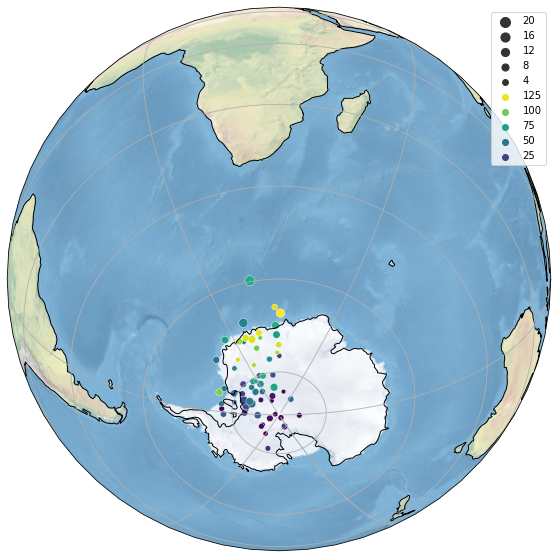

In [6]:
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(30, -60)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = df_NAM['plon'], y = df_NAM['plat'],
                hue = df_NAM['age'],  size = (df_NAM['max_age'] - df_NAM['min_age']) , sizes=(20, 100),
                palette="viridis",
                transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()

### Reading the Virtual Geoomagnetic Poles (VGP)

Here we read all the VGPs data we have in the folder and we concatenate all the information into one single table

In [72]:
data_path_VGP = current_path + "/data/VGPs_NAM"

# this reads the names of all the files in the data path foldel we have
files_names = get_files_in_directory(data_path_VGP)
#files_names

In [73]:
dfs = []
poles = []

for fname in files_names:      
    
    df_tmp = pd.read_excel(fname, skiprows = 5)
    
    df_tmp.insert(0, 'pole_id', fname.replace('.', '/').split('/')[-2])
    df_tmp.insert(1, 'vgp_id', np.arange(1, df_tmp.shape[0]+1))
    
    # Calculates Pole statistics from vgps   
    ipmag.vgp_calc(df_tmp, site_lon='slon', site_lat='slat', dec_tc='dec', inc_tc='inc')
    
    #CRITERIA: if there is no slat/slon in the paper, we get as 'true' the VGP reported in the paper
    df_tmp.vgp_lat.fillna(df_tmp.VGP_lat, inplace=True)
    df_tmp.vgp_lon.fillna(df_tmp.VGP_lon, inplace=True)
        
    df_tmp['vgp_lat_SH'] = np.where(df_tmp['vgp_lat'] > 0, -df_tmp['vgp_lat'], df_tmp['vgp_lat'])
    df_tmp['vgp_lon_SH'] = np.where(df_tmp['vgp_lat'] > 0,(df_tmp['vgp_lon'] - 180.) % 360., df_tmp['vgp_lon'])
     
    #CALCULATES FISHER STATISTICS FROM THE VGP LEVEL    
    mean_tmp = ipmag.fisher_mean(dec = df_tmp['vgp_lon_SH'].tolist(),inc = df_tmp['vgp_lat_SH'].tolist())
        
    poles.append(mean_tmp)    
    dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)

### DataFrame for the Pole statistics calculated from the reported VGPs

In [74]:
poles_from_vgps = pd.DataFrame(poles, index=df['pole_id'].unique().tolist())
poles_from_vgps

,dec,inc,n,r,k,alpha95,csd
VGPs_NAM\1,40.743341,-86.048205,45,42.609202,18.403900,5.096357,18.881221
VGPs_NAM\10,267.711248,-88.340153,17,16.623349,42.479588,5.536743,12.427818
VGPs_NAM\11,239.148090,-67.077683,23,14.859409,2.702506,23.061779,49.272166
VGPs_NAM\12,275.512791,-71.976300,51,40.258736,4.654946,10.414476,37.542891
VGPs_NAM\13,25.393571,-84.827136,24,21.858915,10.742219,9.469288,24.713714
VGPs_NAM\14,263.158239,-65.974838,62,39.321520,2.689775,13.839686,49.388640
VGPs_NAM\16,269.598821,-76.433320,30,27.780393,13.065378,7.561126,22.409080
VGPs_NAM\17,114.947969,-80.327988,10,9.338902,13.613722,13.580354,21.953136
VGPs_NAM\18,352.284567,-78.608970,25,23.293661,14.065203,8.002832,21.597924
VGPs_NAM\19,21.143330,-63.593328,23,19.862668,7.012329,12.323351,30.588198


## Plotting VGPs converted to the southern hemisphere

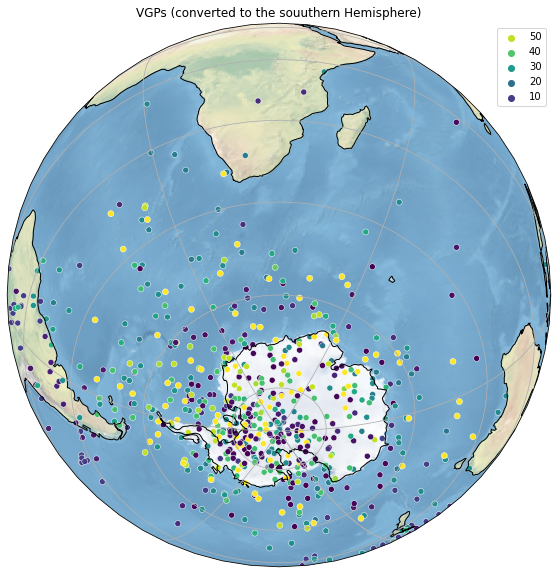

In [70]:
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(30, -60) #Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = df['vgp_lon_SH'], y = df['vgp_lat_SH'],
                hue = df['age'], sizes=(20, 100),
                palette="viridis",
                transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.title('VGPs (converted to the southern Hemisphere)')
plt.show()

### Sites

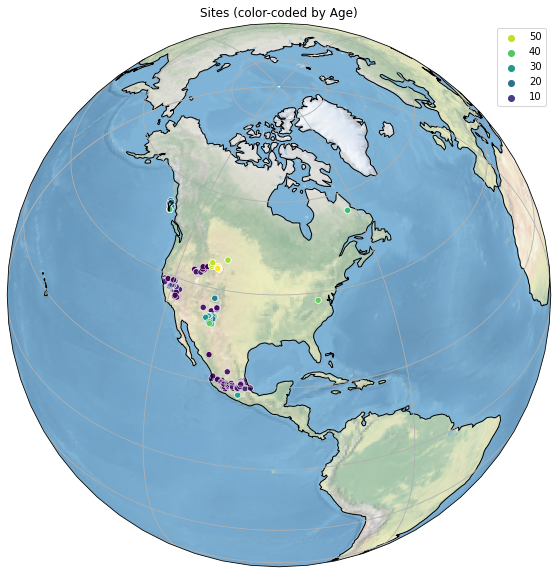

In [79]:
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(-90, 40) #Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = df['slon'], y = df['slat'],
                hue = df['age'], sizes=(20, 100),
                palette="viridis",
                transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.title('Sites (color-coded by Age)')
plt.show()

### Paleomagnetic Poles Calcuated from the VGPs

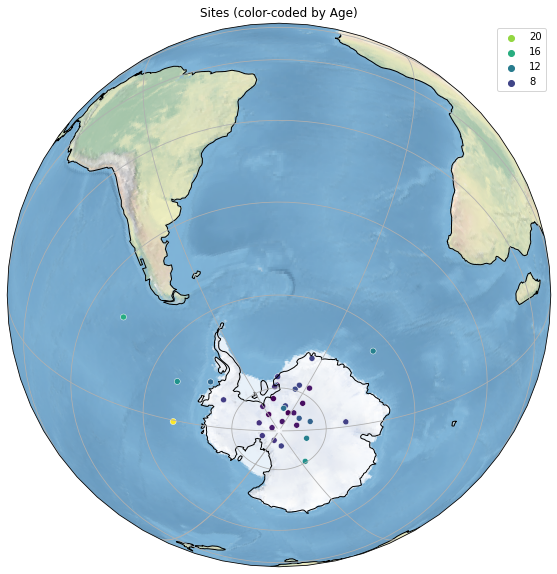

In [82]:
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(-30, -60) #Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = poles_from_vgps['dec'], y = poles_from_vgps['inc'],
                hue = poles_from_vgps['alpha95'], sizes=(20, 100),
                palette="viridis",
                transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.title('Sites (color-coded by Age)')
plt.show()